In [13]:
# ============================================================
# 05_gradcam.ipynb
# Visualisation des activations du modèle ConvNeXt Tiny
# ============================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device utilisé :", device)

Device utilisé : cuda


In [15]:
# Charger state_dict
state_path = "results/training/best_convnext_model.pth"
state_dict = torch.load(state_path, map_location=device)
print(">>> Clés trouvées dans state_dict (exemples) :", list(state_dict.keys())[:20])

# Recréer modèle ConvNeXt tiny (sans poids pré-entrainés)
model = models.convnext_tiny(weights=None)

# Reconstruire exactement le classifier utilisé à l'entraînement
# (Flatten, LayerNorm(768), Dropout(0.3), Linear(768, num_classes))
# Assure-toi que num_classes correspond au modèle sauvegardé
class_names = ["glioma", "meningioma", "notumor", "pituitary"]
num_classes = len(class_names)

model.classifier = nn.Sequential(
    nn.Flatten(),  
    nn.LayerNorm(768, eps=1e-06, elementwise_affine=True),
    nn.Dropout(p=0.3),
    nn.Linear(768, num_classes)
)


C:\Users\user\AppData\Local\Temp\ipykernel_22720\1892215702.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(state_path, map_location=device)


>>> Clés trouvées dans state_dict (exemples) : ['features.0.0.weight', 'features.0.0.bias', 'features.0.1.weight', 'features.0.1.bias', 'features.1.0.layer_scale', 'features.1.0.block.0.weight', 'features.1.0.block.0.bias', 'features.1.0.block.2.weight', 'features.1.0.block.2.bias', 'features.1.0.block.3.weight', 'features.1.0.block.3.bias', 'features.1.0.block.5.weight', 'features.1.0.block.5.bias', 'features.1.1.layer_scale', 'features.1.1.block.0.weight', 'features.1.1.block.0.bias', 'features.1.1.block.2.weight', 'features.1.1.block.2.bias', 'features.1.1.block.3.weight', 'features.1.1.block.3.bias']


In [16]:
# Charger les poids complets (features + classifier)
model.load_state_dict(state_dict)
model = model.to(device)
model.eval()
print("Modèle chargé et prêt.")

# Transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

Modèle chargé et prêt.


In [17]:
# Variables globales pour hooks
activations = None
gradients = None

def save_activation(module, input, output):
    global activations
    # sortie attendue en (B, C, H, W)
    activations = output.detach()

def save_gradient(module, grad_input, grad_output):
    global gradients
    # grad_output peut être un tuple ; on prend le premier élément
    g = grad_output[0] if isinstance(grad_output, tuple) else grad_output
    gradients = g.detach()

In [18]:
# Choisir la couche cible (dernier bloc du dernier stage)
# Pour ConvNeXt, model.features est une nn.Sequential de stages,
# chaque stage contient plusieurs blocks (chaque block renvoie un feature map).
# On attache les hooks au dernier block du dernier stage.
target_layer = model.features[-1][-1]

# Register forward hook pour activations
target_layer.register_forward_hook(save_activation)

# register_full_backward_hook est plus fiable pour les versions récentes de PyTorch
if hasattr(target_layer, "register_full_backward_hook"):
    target_layer.register_full_backward_hook(lambda m, gi, go: save_gradient(m, gi, go))
else:
    # fallback (déprécié mais parfois nécessaire)
    target_layer.register_backward_hook(save_gradient)

In [19]:
# Grad-CAM generator
def generate_gradcam(image_path, return_pil=False):
    global activations, gradients

    # Charger et transformer l'image
    img = Image.open(image_path).convert("RGB")
    img_t = transform(img).unsqueeze(0).to(device)

    # Forward
    activations = None
    gradients = None
    output = model(img_t)                       # (1, num_classes)
    pred_class = output.argmax(dim=1).item()
    score = output[0, pred_class]

    # Backward pour récupérer gradients
    model.zero_grad()
    score.backward(retain_graph=False)

    # Vérifications
    if activations is None:
        raise RuntimeError("Activations non capturées — vérifie le target_layer et les hooks.")
    if gradients is None:
        raise RuntimeError("Gradients non capturés — vérifie le target_layer et les hooks.")

    # activations : (1, C, H, W), gradients : (1, C, H, W)
    # Calcul des poids alpha_k = mean over spatial dims
    weights = gradients.mean(dim=(2, 3), keepdim=True)  # shape (1, C, 1, 1)
    gradcam_map = torch.relu((weights * activations).sum(dim=1, keepdim=False))  # (1, H, W) -> squeeze -> (H,W)
    gradcam_map = gradcam_map.squeeze(0).cpu().numpy()

    # Redimension et normalisation
    gradcam_map = cv2.resize(gradcam_map, (224, 224))
    if gradcam_map.max() - gradcam_map.min() > 1e-8:
        gradcam_map = (gradcam_map - gradcam_map.min()) / (gradcam_map.max() - gradcam_map.min())
    else:
        gradcam_map = np.zeros_like(gradcam_map)

    # Superposition sur image originale
    orig_rgb = np.array(img.resize((224, 224)))  # RGB
    img_bgr = cv2.cvtColor(orig_rgb, cv2.COLOR_RGB2BGR)
    heatmap = cv2.applyColorMap(np.uint8(255 * gradcam_map), cv2.COLORMAP_JET)
    superposed = cv2.addWeighted(img_bgr, 0.6, heatmap, 0.4, 0)

    # Retourne en format affichable par matplotlib (RGB)
    return orig_rgb, cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB), cv2.cvtColor(superposed, cv2.COLOR_BGR2RGB), pred_class


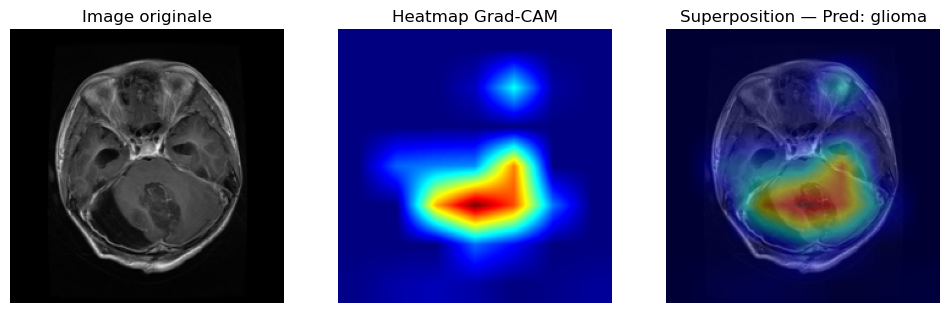

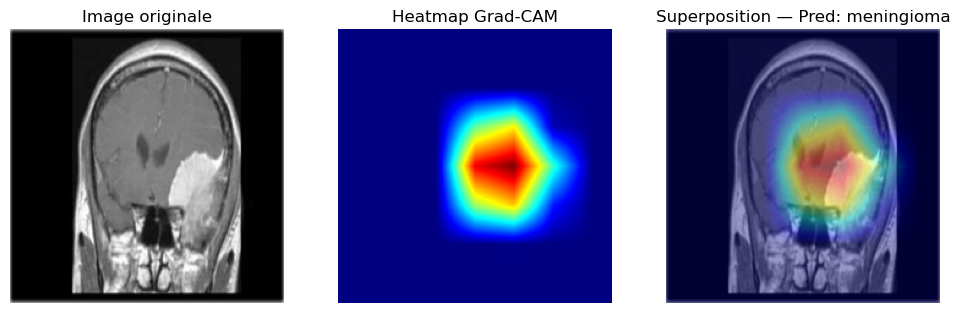

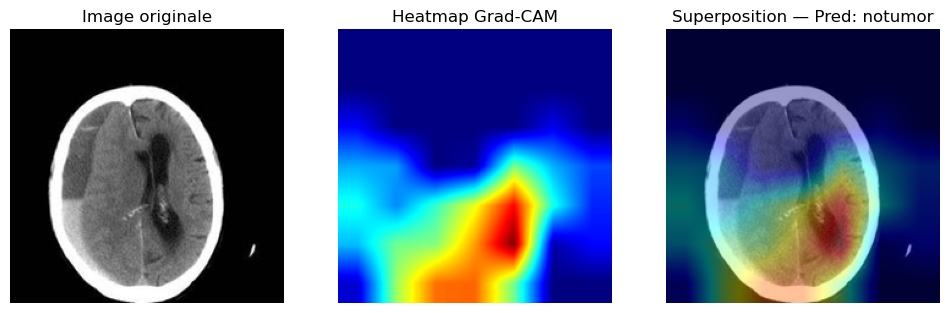

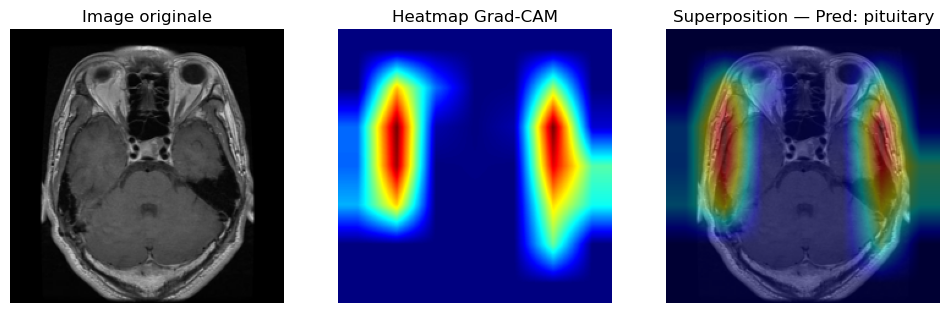

In [20]:
# Exemple d'utilisation (adaptation du chemin test_dir)
test_dir = r"C:/Users/user/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Testing"
examples = []
for cls in class_names:
    folder = os.path.join(test_dir, cls)
    if not os.path.isdir(folder):
        print("Dossier introuvable :", folder)
        continue
    files = [f for f in os.listdir(folder) if f.lower().endswith((".jpg", ".png", ".jpeg"))]
    if not files:
        print("Aucune image dans :", folder)
        continue
    examples.append(os.path.join(folder, files[0]))

# Créer dossier de sauvegarde
save_dir = "results/gradcam"
os.makedirs(save_dir, exist_ok=True)

for img_path in examples:
    orig, heat, superposed, pred = generate_gradcam(img_path)
    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.title("Image originale")
    plt.imshow(orig)
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.title("Heatmap Grad-CAM")
    plt.imshow(heat)
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.title(f"Superposition — Pred: {class_names[pred]}")
    plt.imshow(superposed)
    plt.axis("off")

    filename = os.path.basename(img_path).rsplit(".", 1)[0] + "_gradcam.png"
    plt.savefig(os.path.join(save_dir, filename), dpi=300)
    plt.show()